In [43]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install scikit-learn
# %pip install tensorflow
# %pip install -U imbalanced-learn

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Dropout, LayerNormalization, MultiHeadAttention, Input
from tensorflow.keras.layers import Attention, Reshape
from tensorflow.keras.models import Model

In [45]:
COMMODITY = 'magnesium'

DATE_COLUMN = 'Date'
VALUE_COLUMN = 'Value'  
QUANTITY_COLUMN = 'Std. Quantity (KG)'
UNIT_RATE_COLUMN = 'Std. Unit Rate ($/KG)'
BRENT_OIL_COLUMN = 'Brent Oil Value'
WTI_OIL_COLUMN = 'WTI Oil Value'
SHIP_COUNT_COLUMN = 'ship_count'
PORT_COUNT_COLUMN = 'popular_port_count'

VALUE_SPIKES_COLUMN = 'Value Spikes'  
QUANTITY_SPIKES_COLUMN = 'Std. Quantity (KG) Spikes'
UNIT_RATE_SPIKES_COLUMN = 'Std. Unit Rate ($/KG) Spikes'
BRENT_OIL_SPIKES_COLUMN = 'Brent Oil Value Spikes'
WTI_OIL_SPIKES_COLUMN = 'WTI Oil Value Spikes'
SHIP_COUNT_SPIKES_COLUMN = 'Ship Count Spikes'
PORT_COUNT_SPIKES_COLUMN = 'Port Count Spikes'

FEATURE_COLUMNS = [VALUE_COLUMN, QUANTITY_COLUMN, UNIT_RATE_COLUMN,  WTI_OIL_COLUMN, BRENT_OIL_COLUMN, SHIP_COUNT_COLUMN, PORT_COUNT_COLUMN]
# FEATURE_COLUMNS = [VALUE_COLUMN, QUANTITY_COLUMN, UNIT_RATE_COLUMN,  WTI_OIL_SPIKES_COLUMN, BRENT_OIL_SPIKES_COLUMN]
# FEATURE_COLUMNS = [VALUE_COLUMN, QUANTITY_COLUMN, UNIT_RATE_COLUMN,  WTI_OIL_COLUMN, BRENT_OIL_COLUMN, SHIP_COUNT_SPIKES_COLUMN, PORT_COUNT_SPIKES_COLUMN]
TARGET_COLUMN = 'Price'

ORIGIN_COUNTRY_COLUMN = 'Country of Origin'
DEST_COUNTRY_COLUMN = 'Country of Destination'

PETROL_FILE_PATH = '../../volza/petroleum/petrol_crude_oil_spot_price.csv'
VOLZA_FILE_PATH = f'../../volza/{COMMODITY}/{COMMODITY}.csv'
PRICE_FILE_PATH = f"../../volza/{COMMODITY}/{COMMODITY}_prices.csv"
AIS_POPULAR_FILE_PATH = f'../../ais/ais_ml_features.csv' 

NB_OUTPUT_PATH = f"{COMMODITY}/{COMMODITY}_model_performance (No Balancing).csv"
RUS_OUTPUT_PATH = f"{COMMODITY}/{COMMODITY}_model_performance (Random Under Sampling).csv"
ROS_OUTPUT_PATH = f"{COMMODITY}/{COMMODITY}_model_performance (Random Over Sampling).csv"


SPIKES_THRESHOLD = 2
SPIKES_WINDOW_SIZE = 20
BIN_COUNT = 10
FILL_METHOD = 'ffill'

RANDOM_STATE = 42

In [46]:
# Only keep rows where we have usable quantity units (kg, ton) and standardizing it.
def convert_to_kg(df, quantity_col='Std. Quantity', unit_col='Std. Unit'):
    converstion_factors = {
        'TON': 907.185,
        'TNE': 1000,
        'KGS': 1,
        'Kgs': 1,
    }

    df_filtered = df[df[unit_col].isin(converstion_factors.keys())]

    def convert(row):
        unit = row[unit_col]
        quantity = row[quantity_col]
        return quantity * converstion_factors.get(unit,1)
    
    df_filtered = df_filtered[df_filtered[VALUE_COLUMN] != 0]
    df_filtered[QUANTITY_COLUMN] = df_filtered.apply(convert, axis=1)
    df_filtered = df_filtered[df_filtered[QUANTITY_COLUMN] != 0]

    df_filtered[UNIT_RATE_COLUMN] = df_filtered[VALUE_COLUMN] / df_filtered[QUANTITY_COLUMN]

    return df_filtered

## Dataframe Prep

In [47]:
from datetime import datetime

#Formatting the date and price for Volza data
volza_pd = pd.read_csv(VOLZA_FILE_PATH)
volza_pd = volza_pd[(volza_pd["Country of Origin"].notnull()) & (volza_pd["Country of Destination"].notnull())]
volza_pd = volza_pd.rename(columns={'Unnamed: 0': 'ID'})
volza_pd['Date'] = volza_pd['Date'].apply(lambda x: x.split(' ')[0])
volza_pd['Date'] = pd.to_datetime(volza_pd['Date'], errors='raise', format='%Y-%m-%d')
volza_pd = convert_to_kg(volza_pd)
volza_pd.head(3)

,ID,Date,HS Code,Product Description,Consignee,Notify Party Name,Shipper,Std. Quantity,Std. Unit,Standard Unit Rate INR,...,Freight Term,Marks Number,HS Product Description,Gross Weight,Consignee Address,Shipper Address,Notify Party Address,Country Name,Std. Quantity (KG),Std. Unit Rate ($/KG)
0,0,2020-06-09,8104110000,MAGNESIUM METALLIC,CORPORACION ECUATORIANA DE ALUMINIO S A CEDAL,NaN,Ningbo Distant Chemicals Co Ltd,5984.0,KGS,-,...,-,-,Con un contenido de magnesio superior o igual ...,0.0,NaN,"Jingjia Road 188 Long Unit, Jiangdong, Ningbo,...",NaN,Ecuador T3+ Import,5984.0,3.025790
1,1,2020-11-25,8104110000,MAGNESIUM METALLIC INGOTS 99.95%,CORPORACION ECUATORIANA DE ALUMINIO S A CEDAL,NaN,Ningbo Distant Chemicals Co Ltd,3000.0,KGS,-,...,-,-,Con un contenido de magnesio superior o igual ...,0.0,NaN,"Jingjia Road 188 Long Unit, Jiangdong, Ningbo,...",NaN,Ecuador T3+ Import,3000.0,3.057833
3,3,2020-07-30,81041100,MAGNESIUM INGOT,PT LAUTAN LUAS TBK,NaN,POINTER INVESTEMT HK LTD,25.0,TNE,-,...,-,-,NaN,0.0,"Graha Indramas, Gedung, Jl. Ks. Tubun No.77, R...",RM 3408 CHINA MERCHANTS TOWER|SHUN TAK CENTRE ...,NaN,Indonesia T3 Import,25000.0,1.940000


In [48]:
#Preprocessing the AIS data
ais_popular_pd = pd.read_csv(AIS_POPULAR_FILE_PATH)
ais_popular_pd['Date'] = pd.to_datetime(ais_popular_pd['Date'])
ais_popular_pd.head(3)


,Date,ship_count,popular_port,popular_port_count
0,2020-11-10,8,LTKLJ,18
1,2020-11-12,20,IDSKP,8
2,2020-11-29,9,CNSHA,2


In [49]:
#Preprocessing the price data
prices_pd = pd.read_csv(PRICE_FILE_PATH)
prices_pd['Date'] = prices_pd['Date'].apply(lambda x: datetime.strptime(x, "%b %d, %Y").strftime("%Y-%m-%d"))
prices_pd['Date'] = pd.to_datetime(prices_pd['Date'], errors='raise', format='%Y-%m-%d')
prices_pd['Price'] = prices_pd['Price'].str.replace(',', '').astype(float)
prices_pd = prices_pd[['Date','Price']]
prices_pd.head(3)

,Date,Price
0,2022-12-30,21650.0
1,2022-12-29,21650.0
2,2022-12-28,21650.0


In [50]:
#Aggregate volza data by day
date_wise_volza = volza_pd.groupby("Date")[[VALUE_COLUMN,QUANTITY_COLUMN,'Gross Weight']].sum()

In [51]:
# Avg of Commodity Price in Volza
avg_price_volza = volza_pd.groupby('Date')[UNIT_RATE_COLUMN].mean()
date_wise_volza = date_wise_volza.join(avg_price_volza, how='left')
date_wise_volza

,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG)
Date,,,,
2020-01-01,3.716627e+07,1.451213e+07,275000.0,8.582012
2020-01-02,1.125000e+05,5.000000e+04,50080.0,2.250000
2020-01-03,8.744076e+05,1.001723e+05,25040.0,768.449153
2020-01-04,2.950597e+05,1.350000e+05,0.0,2.188610
2020-01-05,4.420000e+04,2.000000e+04,0.0,2.210000
...,...,...,...,...
2022-12-27,9.624998e+04,2.500000e+04,25040.0,3.849999
2022-12-28,1.122651e+06,2.869969e+05,80306.0,5.656118
2022-12-29,1.303649e+06,3.568780e+05,0.0,3.490332


In [52]:
# Petroleum data prep
petrol_df = pd.read_csv(PETROL_FILE_PATH, delimiter=';', on_bad_lines='warn')
petrol_df['Date'] = pd.to_datetime(petrol_df['Date'])

# Split based on types of oil
brent_df = petrol_df[petrol_df['product-name']=='UK Brent Crude Oil']
wti_df = petrol_df[petrol_df['product-name']=='WTI Crude Oil']

brent_df.rename(columns={'Value':'Brent Oil Value'}, inplace=True)
wti_df.rename(columns={'Value':'WTI Oil Value'}, inplace=True)


C:\Users\manim\AppData\Local\Temp\ipykernel_38356\273638861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brent_df.rename(columns={'Value':'Brent Oil Value'}, inplace=True)
C:\Users\manim\AppData\Local\Temp\ipykernel_38356\273638861.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_df.rename(columns={'Value':'WTI Oil Value'}, inplace=True)


In [53]:
# Combining dataframes
prices_pd = prices_pd.set_index('Date')
ais_popular_pd = ais_popular_pd.set_index('Date')
date_wise_volza = date_wise_volza.join(ais_popular_pd, how="left").fillna(method=FILL_METHOD)
aggregated_df = date_wise_volza.join(prices_pd, how="left").fillna(method=FILL_METHOD)
aggregated_df = aggregated_df.merge(brent_df[[DATE_COLUMN, BRENT_OIL_COLUMN]], on='Date', how='left').fillna(method=FILL_METHOD)
aggregated_df = aggregated_df.merge(wti_df[[DATE_COLUMN, WTI_OIL_COLUMN]], on='Date', how='left').fillna(method=FILL_METHOD)
aggregated_df

C:\Users\manim\AppData\Local\Temp\ipykernel_38356\1674725426.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  date_wise_volza = date_wise_volza.join(ais_popular_pd, how="left").fillna(method=FILL_METHOD)
C:\Users\manim\AppData\Local\Temp\ipykernel_38356\1674725426.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aggregated_df = date_wise_volza.join(prices_pd, how="left").fillna(method=FILL_METHOD)
C:\Users\manim\AppData\Local\Temp\ipykernel_38356\1674725426.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aggregated_df = aggregated_df.merge(brent_df[[DATE_COLUMN, BRENT_OIL_COLUMN]], on='Date', how='left').fillna(method=FILL_METHOD)
C:\Users\manim\AppData\Local\Temp\ipykernel_38356\1674725426.py:7: FutureWa

,Date,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG),ship_count,popular_port,popular_port_count,Price,Brent Oil Value,WTI Oil Value
0,2020-01-01,3.716627e+07,1.451213e+07,275000.0,8.582012,NaN,NaN,NaN,NaN,67.77,61.14
1,2020-01-02,1.125000e+05,5.000000e+04,50080.0,2.250000,NaN,NaN,NaN,14150.0,67.05,61.17
2,2020-01-03,8.744076e+05,1.001723e+05,25040.0,768.449153,NaN,NaN,NaN,14100.0,69.08,63.00
3,2020-01-04,2.950597e+05,1.350000e+05,0.0,2.188610,NaN,NaN,NaN,14100.0,69.08,63.00
4,2020-01-05,4.420000e+04,2.000000e+04,0.0,2.210000,NaN,NaN,NaN,14100.0,69.08,63.00
...,...,...,...,...,...,...,...,...,...,...,...
964,2022-12-27,9.624998e+04,2.500000e+04,25040.0,3.849999,27245.0,SGSIN,9195.0,21700.0,82.45,79.45
965,2022-12-28,1.122651e+06,2.869969e+05,80306.0,5.656118,26021.0,SGSIN,9233.0,21650.0,81.70,78.89
966,2022-12-29,1.303649e+06,3.568780e+05,0.0,3.490332,24039.0,SGSIN,8861.0,21650.0,80.96,78.43
967,2022-12-30,9.095473e+05,2.128420e+05,44080.0,3.949859,19952.0,SGSIN,8118.0,21650.0,82.82,80.16


In [54]:
def detect_spikes(df, column):
    ## Detecting spikes
    moving_avg = df[column].rolling(window=SPIKES_WINDOW_SIZE).mean()
    std_dev = df[column].rolling(window=SPIKES_WINDOW_SIZE).std()

    # Set a threshold to identify spikes
    return (abs(aggregated_df[column] - moving_avg) > SPIKES_THRESHOLD * std_dev).astype(int)

aggregated_df['spikes'] = detect_spikes(aggregated_df, 'Price')
print("SPIKES : NON SPIKES = ")
print(aggregated_df['spikes'].value_counts())
print("PERCENT OF SPIKES", aggregated_df['spikes'].value_counts()[1]/len(aggregated_df))

SPIKES : NON SPIKES = 
spikes
0    816
1    153
Name: count, dtype: int64
PERCENT OF SPIKES 0.15789473684210525


# **Detect spikes**

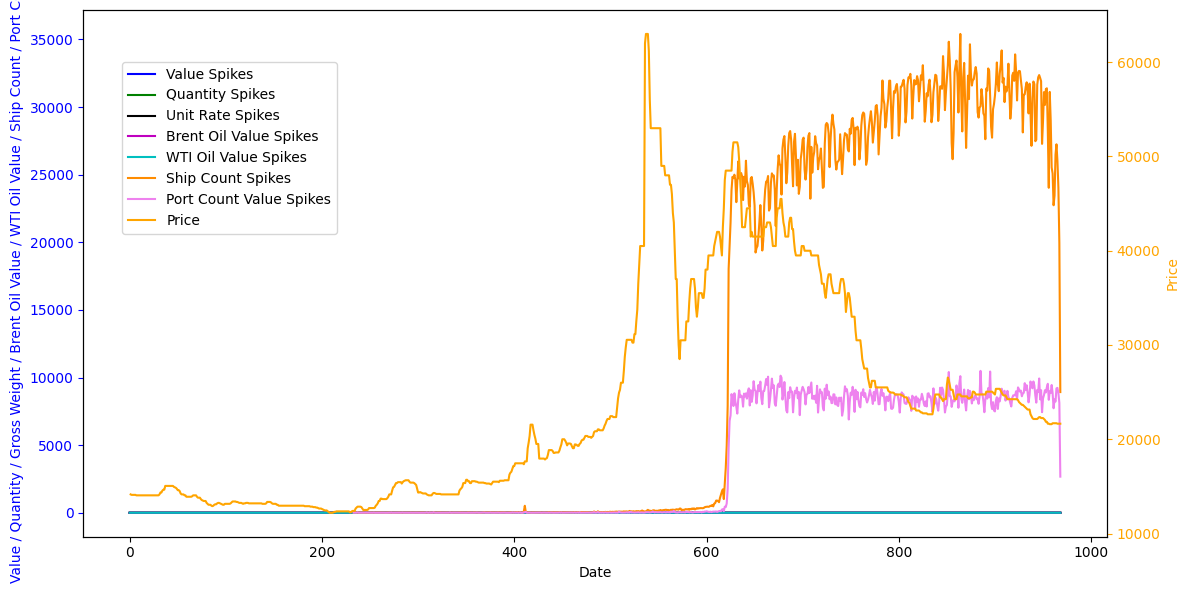

In [55]:
aggregated_df[VALUE_SPIKES_COLUMN] = detect_spikes(aggregated_df, VALUE_COLUMN)
aggregated_df[QUANTITY_SPIKES_COLUMN] = detect_spikes(aggregated_df, QUANTITY_COLUMN)
aggregated_df[UNIT_RATE_SPIKES_COLUMN] = detect_spikes(aggregated_df, UNIT_RATE_COLUMN)
aggregated_df[WTI_OIL_SPIKES_COLUMN] = detect_spikes(aggregated_df, WTI_OIL_COLUMN)
aggregated_df[BRENT_OIL_SPIKES_COLUMN] = detect_spikes(aggregated_df, BRENT_OIL_COLUMN)
aggregated_df[SHIP_COUNT_SPIKES_COLUMN] = detect_spikes(aggregated_df, SHIP_COUNT_COLUMN)
aggregated_df[PORT_COUNT_SPIKES_COLUMN] = detect_spikes(aggregated_df, PORT_COUNT_COLUMN)

#Visualise Dataset

# Plotting the graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting 'Value', 'Quantity', and 'Gross Weight' on the left y-axis
ax1.plot(aggregated_df.index, aggregated_df[VALUE_SPIKES_COLUMN], label='Value Spikes', color='b')
ax1.plot(aggregated_df.index, aggregated_df[QUANTITY_SPIKES_COLUMN], label='Quantity Spikes', color='g')
ax1.plot(aggregated_df.index, aggregated_df[UNIT_RATE_SPIKES_COLUMN], label='Unit Rate Spikes', color='k')
ax1.plot(aggregated_df.index, aggregated_df[BRENT_OIL_SPIKES_COLUMN], label='Brent Oil Value Spikes', color='m')
ax1.plot(aggregated_df.index, aggregated_df[WTI_OIL_SPIKES_COLUMN], label='WTI Oil Value Spikes', color='c')
ax1.plot(aggregated_df.index, aggregated_df[SHIP_COUNT_COLUMN], label='Ship Count Spikes', color='darkorange')
ax1.plot(aggregated_df.index, aggregated_df[PORT_COUNT_COLUMN], label='Port Count Value Spikes', color='violet')

ax1.set_xlabel('Date')
ax1.set_ylabel('Value / Quantity / Gross Weight / Brent Oil Value / WTI Oil Value / Ship Count / Port Count ', color='b')
ax1.tick_params('y', colors='b')

# Creating a second y-axis for 'Price'
ax2 = ax1.twinx()
ax2.plot(aggregated_df.index, aggregated_df['Price'], label='Price', color='orange')
ax2.set_ylabel('Price', color='orange')
ax2.tick_params('y', colors='orange')

# Display legend
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the graph
# plt.show()

In [56]:
#remove date 2020-01-01
aggregated_df = aggregated_df[aggregated_df.index != '2020-01-01']
aggregated_df

,Date,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG),ship_count,popular_port,popular_port_count,Price,Brent Oil Value,WTI Oil Value,spikes,Value Spikes,Std. Quantity (KG) Spikes,Std. Unit Rate ($/KG) Spikes,WTI Oil Value Spikes,Brent Oil Value Spikes,Ship Count Spikes,Port Count Spikes
0,2020-01-01,3.716627e+07,1.451213e+07,275000.0,8.582012,NaN,NaN,NaN,NaN,67.77,61.14,0,0,0,0,0,0,0,0
1,2020-01-02,1.125000e+05,5.000000e+04,50080.0,2.250000,NaN,NaN,NaN,14150.0,67.05,61.17,0,0,0,0,0,0,0,0
2,2020-01-03,8.744076e+05,1.001723e+05,25040.0,768.449153,NaN,NaN,NaN,14100.0,69.08,63.00,0,0,0,0,0,0,0,0
3,2020-01-04,2.950597e+05,1.350000e+05,0.0,2.188610,NaN,NaN,NaN,14100.0,69.08,63.00,0,0,0,0,0,0,0,0
4,2020-01-05,4.420000e+04,2.000000e+04,0.0,2.210000,NaN,NaN,NaN,14100.0,69.08,63.00,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964,2022-12-27,9.624998e+04,2.500000e+04,25040.0,3.849999,27245.0,SGSIN,9195.0,21700.0,82.45,79.45,0,0,0,0,0,0,0,0
965,2022-12-28,1.122651e+06,2.869969e+05,80306.0,5.656118,26021.0,SGSIN,9233.0,21650.0,81.70,78.89,0,0,0,0,0,0,0,0
966,2022-12-29,1.303649e+06,3.568780e+05,0.0,3.490332,24039.0,SGSIN,8861.0,21650.0,80.96,78.43,0,0,0,0,0,0,0,0
967,2022-12-30,9.095473e+05,2.128420e+05,44080.0,3.949859,19952.0,SGSIN,8118.0,21650.0,82.82,80.16,0,0,0,0,0,0,1,0


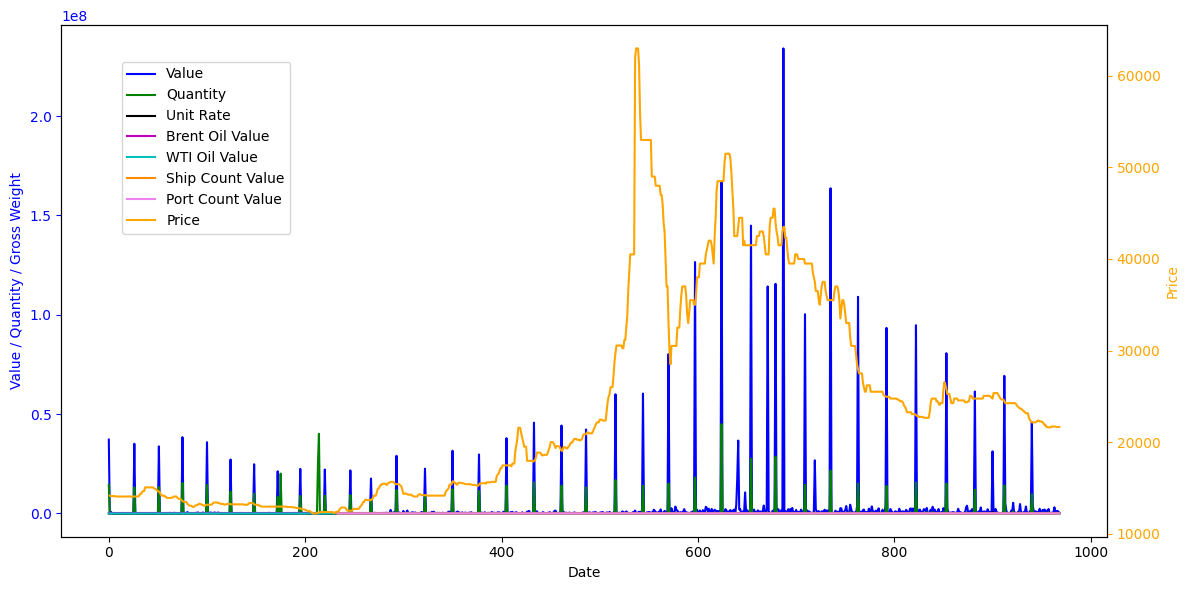

In [57]:
#Visualise Dataset
# Plotting the graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting 'Value', 'Quantity', and 'Gross Weight' on the left y-axis
ax1.plot(aggregated_df.index, aggregated_df[VALUE_COLUMN], label='Value', color='b')
ax1.plot(aggregated_df.index, aggregated_df[QUANTITY_COLUMN], label='Quantity', color='g')
ax1.plot(aggregated_df.index, aggregated_df[UNIT_RATE_COLUMN], label='Unit Rate', color='k')
ax1.plot(aggregated_df.index, aggregated_df[BRENT_OIL_COLUMN], label='Brent Oil Value', color='m')
ax1.plot(aggregated_df.index, aggregated_df[WTI_OIL_COLUMN], label='WTI Oil Value', color='c')
ax1.plot(aggregated_df.index, aggregated_df[SHIP_COUNT_COLUMN], label='Ship Count Value', color='darkorange')
ax1.plot(aggregated_df.index, aggregated_df[PORT_COUNT_COLUMN], label='Port Count Value', color='violet')

ax1.set_xlabel('Date')
ax1.set_ylabel('Value / Quantity / Gross Weight', color='b')
ax1.tick_params('y', colors='b')

# Creating a second y-axis for 'Price'
ax2 = ax1.twinx()
ax2.plot(aggregated_df.index, aggregated_df['Price'], label='Price', color='orange')
ax2.set_ylabel('Price', color='orange')
ax2.tick_params('y', colors='orange')

# Display legend
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the graph
# plt.show()

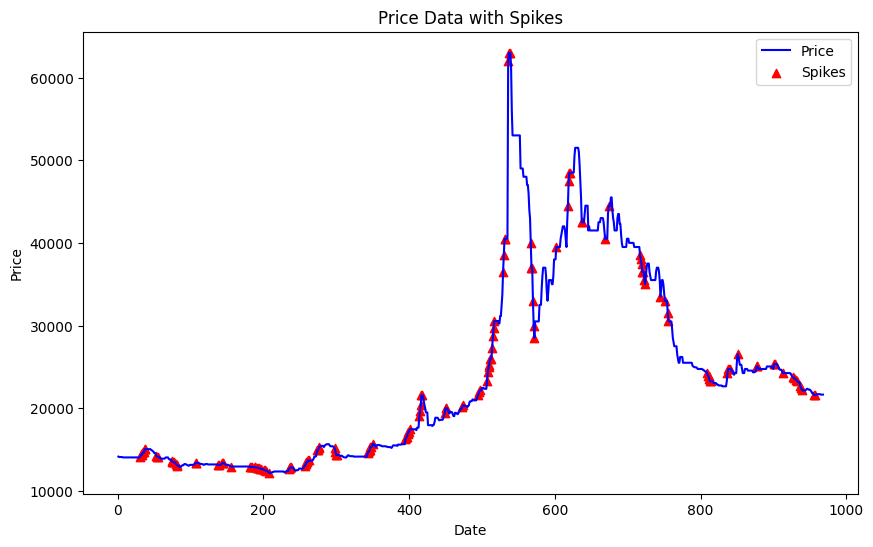

In [58]:
# Plotting the price data
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(aggregated_df.index, aggregated_df['Price'], label='Price', color='blue')

# Highlighting spikes
spike_indices = aggregated_df[aggregated_df['spikes'] == 1].index
spike_prices = aggregated_df.loc[spike_indices, 'Price']
plt.scatter(spike_indices, spike_prices, color='red', marker='^', label='Spikes')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Data with Spikes')
plt.legend()

# Display the plot
# plt.show()

## Baseline

In [59]:
# Count % of spikes 
total_spikes = aggregated_df['spikes'].sum()
total_data_points = len(aggregated_df)
percentage_of_spikes = (total_spikes / total_data_points) * 100

print(f"Percentage of Spikes: {percentage_of_spikes:.2f}%")

Percentage of Spikes: 15.79%


In [60]:
from sklearn.metrics import precision_score, recall_score

# Probability of spike
spike_prob = aggregated_df['spikes'].mean()

# Random baseline predictions
random_predictions = np.random.choice([0, 1], size=len(aggregated_df), p=[1-spike_prob, spike_prob])

# Calculate precision and recall for the random baseline
random_precision = precision_score(aggregated_df['spikes'], random_predictions)
random_recall = recall_score(aggregated_df['spikes'], random_predictions)

print(f"Random Guessing Precision: {random_precision}")
print(f"Random Guessing Recall: {random_recall}")


Random Guessing Precision: 0.08450704225352113
Random Guessing Recall: 0.0784313725490196


## Data Prep for Classification

In [61]:
COLUMNS = FEATURE_COLUMNS + [TARGET_COLUMN]
print(COLUMNS)

['Value', 'Std. Quantity (KG)', 'Std. Unit Rate ($/KG)', 'WTI Oil Value', 'Brent Oil Value', 'ship_count', 'popular_port_count', 'Price']


In [62]:
# # Discretize
# from sklearn.preprocessing import KBinsDiscretizer

# def discretize(df, columns, bins):
#     est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='kmeans')
#     df[columns] = est.fit_transform(df[columns])
#     return df

# # FEATURES_1 = [VALUE_COLUMN, QUANTITY_COLUMN, UNIT_RATE_COLUMN]
# # FEATURES_2 = [WTI_OIL_COLUMN, BRENT_OIL_COLUMN]

# test_df = aggregated_df.copy()
# test_df[FEATURE_COLUMNS] = test_df[FEATURE_COLUMNS].fillna(0)

# # test_df = discretize(test_df, FEATURES_1, 2)
# # test_df = discretize(test_df, FEATURES_2, BIN_COUNT)
# discretized_df = discretize(test_df, FEATURE_COLUMNS, BIN_COUNT)
# # discretized_df = test_df.copy()
# test_df.head(2)


In [63]:
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Plotting 'Value', 'Quantity', and 'Gross Weight' on the left y-axis
# ax1.plot(test_df.index, test_df[VALUE_COLUMN], label='Value', color='b')
# ax1.plot(test_df.index, test_df[QUANTITY_COLUMN], label='Quantity', color='g')
# ax1.plot(test_df.index, test_df[UNIT_RATE_COLUMN], label='Unit Rate', color='k')
# ax1.plot(test_df.index, test_df[BRENT_OIL_COLUMN], label='Brent Oil Value', color='m')
# ax1.plot(test_df.index, test_df[WTI_OIL_COLUMN], label='WTI Oil Value', color='c')
# ax1.plot(test_df.index, test_df[SHIP_COUNT_COLUMN], label='Ship Count Value', color='darkorange')
# ax1.plot(test_df.index, test_df[PORT_COUNT_COLUMN], label='Port Count Value', color='violet')

# ax1.set_xlabel('Date')
# ax1.set_ylabel('Value / Quantity / Gross Weight', color='b')
# ax1.tick_params('y', colors='b')

# # Creating a second y-axis for 'Price'
# ax2 = ax1.twinx()
# ax2.plot(test_df.index, test_df['Price'], label='Price', color='orange')
# ax2.set_ylabel('Price', color='orange')
# ax2.tick_params('y', colors='orange')

# # Display legend
# fig.tight_layout()
# fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# # Display the graph
# plt.show()

In [64]:
# # Convert the discretized data into a DataFrame
# discretized_df = pd.DataFrame(discretized_df, columns=FEATURE_COLUMNS)

# unique_values = discretized_df[VALUE_COLUMN].fillna(method=FILL_METHOD).unique()
# print(unique_values)

# bin_counts = {col: discretized_df[col].value_counts() for col in FEATURE_COLUMNS}

# # Plotting
# plt.figure(figsize=(15, len(FEATURE_COLUMNS) * 5))

# for i, column in enumerate(FEATURE_COLUMNS):
#     plt.subplot(len(FEATURE_COLUMNS), 1, i + 1)
#     bin_counts[column].sort_index().plot(kind='bar', ax=plt.gca())

#     plt.title(f'{column} Distribution')
#     plt.ylabel('Frequency')
#     plt.xlabel('Bins')

# plt.tight_layout()
# plt.show()


In [65]:
# Clean up before passing to Arima
initial_row_count = aggregated_df.shape[0]

columns_of_interest = ['Price', 'spikes']  # Add other columns as necessary

aggregated_df = aggregated_df.dropna(subset=columns_of_interest)

rows_dropped = initial_row_count - aggregated_df.shape[0]

print(f"Rows dropped due to NaN values: {rows_dropped}")

Rows dropped due to NaN values: 1


## Train / Test Set Up

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, SimpleRNN
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pmdarima as pm
# from pmdarima.model_selection import train_test_split

# Fit an Auto ARIMA model to the 'Price' series
model = pm.auto_arima(aggregated_df['Price'], seasonal=True, m=12, suppress_warnings=True, stepwise=True, error_action='ignore')

# Forecast the series using the model (in-sample prediction)
forecast = model.predict_in_sample()

# Calculate residuals (difference between actual and forecasted values)
residuals = aggregated_df['Price'] - forecast

# Append residuals to DataFrame as a new feature (using residuals as a way to detect spike / anomaly)
aggregated_df = aggregated_df.copy()
aggregated_df['ARIMA_Residuals'] = residuals

FEATURE_COLUMNS = [TARGET_COLUMN, 'ARIMA_Residuals']  # Add other feature columns as necessary
# FEATURE_COLUMNS = [TARGET_COLUMN]  # Add other feature columns as necessary
X = aggregated_df[FEATURE_COLUMNS].values
y = aggregated_df['spikes'].values

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create sequences for each sample with a window size of 20
SPIKES_WINDOW_SIZE = 20
X_sequences, y_sequences = [], []

for i in range(len(X_scaled) - SPIKES_WINDOW_SIZE + 1):
    X_sequences.append(X_scaled[i:i + SPIKES_WINDOW_SIZE, :])
    y_sequences.append(y[i + SPIKES_WINDOW_SIZE - 1])

X_sequences, y_sequences = np.array(X_sequences), np.array(y_sequences)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=50, shuffle=False)

## Evaluation

In [67]:
def make_output_dict(name, params, classification_report):
    return {
        "Name": name,
        "Params": params,
        "Accuracy": classification_report["accuracy"],
        "Precision (0)": classification_report["0"]["precision"],
        "Recall (0)": classification_report["0"]["recall"],
        "F1 (0)": classification_report["0"]["f1-score"],
        "Precision (1)": classification_report["1"]["precision"],
        "Recall (1)": classification_report["1"]["recall"],
        "F1 (1)": classification_report["1"]["f1-score"],
    }

output_dicts = []

In [68]:
# Transformer
def positional_encoding(length, d_model):
    def get_angles(pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    angle_rads = get_angles(np.arange(length)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
    
    # Apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # Apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
      
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

def transformer_encoder(inputs, num_heads, ff_dim, dropout=0.1):
    # Multi-head self-attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    # Feed-forward layer
    ff_output = Dense(ff_dim, activation="relu")(attention_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    return LayerNormalization(epsilon=1e-6)(attention_output + ff_output)

# Model configuration
length = SPIKES_WINDOW_SIZE  
d_model = len(FEATURE_COLUMNS) 

def build_transformer(num_encoder_layers):
    inputs = Input(shape=(length, d_model))
    x = inputs + positional_encoding(length, d_model)

    for _ in range(num_encoder_layers):
        x = transformer_encoder(x, num_heads=4, ff_dim=128)

    x = Flatten()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Evaluate Transformer model
def evaluate_transformer(num_encoder_layers):
    model = build_transformer(num_encoder_layers)
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)

    y_pred = (model.predict(X_test) > 0.5).astype(int)
    report = classification_report(y_test, y_pred, output_dict=True)
    output = make_output_dict(f"Transformer", f"{num_encoder_layers} encoder layers", report)
    return y_pred, output


In [69]:
#LSTM Model
def evaluate_lstm(num_layers: int):
  # Build the LSTM model
  model = Sequential()
  model.add(LSTM(num_layers, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

  # Train the model
  model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)

  y_pred = (model.predict(X_test) > 0.5).astype(int)
  output = make_output_dict(f"LSTM", f"{num_layers} layers", classification_report(y_test, y_pred, output_dict=True))
  return y_pred, output


In [70]:
def evaluate_rnn(num_units: int):
    # Build the RNN model
    model = Sequential()
    model.add(SimpleRNN(num_units, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)

    # Predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    output = make_output_dict("RNN", f"{num_units} units", classification_report(y_test, y_pred, output_dict=True))

    # Generate classification report
    return y_pred, output

In [71]:
# Build the CNN model
def evaluate_cnn(num_filters: int, kernel_size: int):

    model = Sequential()
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)

    # Predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    output = make_output_dict("CNN", f"{num_filters} filters, kernel size {kernel_size}", classification_report(y_test, y_pred, output_dict=True))

    # Generate classification report
    return y_pred, output


In [72]:
# Attention CNN
def create_acnn_model(input_shape, num_classes, filters, kernel_size):
    inputs = tf.keras.Input(shape=input_shape)

    # CNN layers
    conv1 = Conv1D(filters, kernel_size=kernel_size, activation='relu')(inputs)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    # Calculate the new shape for dynamic reshaping
    conv_shape = conv1.shape.as_list()
    new_shape = (-1, conv_shape[1] * conv_shape[2] // 2)

    # Reshape for attention
    reshape = Reshape(new_shape)(pool1)

    # Attention mechanism
    attention = Attention()([reshape, reshape])

    # Flatten for fully connected layers
    flatten = Flatten()(attention)

    # Fully connected layers
    dense1 = Dense(128, activation='relu')(flatten)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(num_classes, activation='softmax')(dropout)

    model = Model(inputs=inputs, outputs=outputs)

    return model

def evaluate_attention_cnn(filters, kernel_size):
    model = create_acnn_model(X_train.shape[1:], 2, filters, kernel_size)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=100, batch_size=filters, verbose=False)
    y_pred = model.predict(X_test)
    output = make_output_dict("CNN with Attention", f"{filters} filters, kernel size {kernel_size}", classification_report(y_test, y_pred.argmax(axis=1), output_dict=True))
    return y_pred, output

## Save Predictions

In [73]:
def save_predictions_to_file(model_name, y_pred, y_true=None, file_format="npy"):
    if file_format == "npy":
        # Save as NumPy binary file
        np.save(f"results/{COMMODITY}/pred/{model_name}_predictions.npy", y_pred)
        if y_true is not None:
            np.save(f"results/{COMMODITY}/true/{model_name}_true_labels.npy", y_true)
    elif file_format == "csv":
        # Save as CSV for easier readability
        df = pd.DataFrame({"Predictions": y_pred.flatten()})
        if y_true is not None:
            df["True Labels"] = y_true
        df.to_csv(f"results/{COMMODITY}/.csv/{model_name}_predictions.csv", index=False)
    else:
        raise ValueError("Unsupported file format. Use 'npy' or 'csv'.")

In [74]:
# # df = pd.read_csv(f'input/{COMMODITY}-lstm-100.csv')
# df

## LSTM 

In [75]:
# #LSTM Model

for layers in [250, 200, 100, 50]:
    y_pred, output_dict = evaluate_lstm(layers)
    output_dicts.append(output_dict)
    # save_predictions_to_file(f"LSTM_{layers}_layers", y_pred, y_test)


6/6 [==============================] - 0s 2ms/step


## CNN w/ Attention

In [76]:
for filter in [32, 64, 128, 256]:
    for kernel in [7,5,3]:
        y_pred, output_dict = evaluate_attention_cnn(filter, kernel)
        output_dicts.append(output_dict)
        # save_predictions_to_file(f"CNN_Attention_{filter}_filters_{kernel}_kernels", y_pred, y_test)

6/6 [==============================] - 0s 2ms/step


## RNN

In [77]:
for units in [200,150,100,50]:
    y_pred, output_dict = evaluate_rnn(units)
    output_dicts.append(output_dict)
    # save_predictions_to_file(f"RNN_{units}_units", y_pred, y_test)


6/6 [==============================] - 0s 1ms/step


## CNN

In [78]:
for filter in [32, 64, 128, 256]:
    for kernel in [7,5,3]:
        y_pred, output_dict = evaluate_cnn(filter, kernel)
        output_dicts.append(output_dict)
        # save_predictions_to_file(f"CNN_{filter}_filters_{kernel}_kernels", y_pred, y_test)

6/6 [==============================] - 0s 1ms/step


## Transformer

In [79]:
# output_dicts.append(evaluate_transformer(1))
# output_dicts.append(evaluate_transformer(2))
# output_dicts.append(evaluate_transformer(3))
# output_dicts.append(evaluate_transformer(4))

In [80]:
output_dicts = pd.DataFrame(output_dicts)
output_dicts.to_csv(NB_OUTPUT_PATH)
output_dicts

,Name,Params,Accuracy,Precision (0),Recall (0),F1 (0),Precision (1),Recall (1),F1 (1)
0,LSTM,250 layers,0.900000,0.919540,0.969697,0.943953,0.687500,0.44,0.536585
1,LSTM,200 layers,0.900000,0.929412,0.957576,0.943284,0.650000,0.52,0.577778
2,LSTM,100 layers,0.863158,0.911243,0.933333,0.922156,0.476190,0.40,0.434783
3,LSTM,50 layers,0.873684,0.932515,0.921212,0.926829,0.518519,0.56,0.538462
4,CNN with Attention,"32 filters, kernel size 7",0.936842,0.952663,0.975758,0.964072,0.809524,0.68,0.739130
5,CNN with Attention,"32 filters, kernel size 5",0.926316,0.946746,0.969697,0.958084,0.761905,0.64,0.695652
6,CNN with Attention,"32 filters, kernel size 3",0.931579,0.952381,0.969697,0.960961,0.772727,0.68,0.723404
7,CNN with Attention,"64 filters, kernel size 7",0.947368,0.964072,0.975758,0.969880,0.826087,0.76,0.791667
8,CNN with Attention,"64 filters, kernel size 5",0.936842,0.963636,0.963636,0.963636,0.760000,0.76,0.760000
9,CNN with Attention,"64 filters, kernel size 3",0.936842,0.952663,0.975758,0.964072,0.809524,0.68,0.739130


## Other

In [81]:
def evaluate_all_models(output_file_name):
  output_dicts = []
  output_dicts.append(evaluate_lstm(250))
  output_dicts.append(evaluate_lstm(200))
  output_dicts.append(evaluate_lstm(100))
  output_dicts.append(evaluate_lstm(50))

  output_dicts.append(evaluate_attention_cnn(32, 5))
  output_dicts.append(evaluate_attention_cnn(64, 5))
  output_dicts.append(evaluate_attention_cnn(128, 5))
  output_dicts.append(evaluate_attention_cnn(256, 5))
  output_dicts.append(evaluate_attention_cnn(64, 3))
  output_dicts.append(evaluate_attention_cnn(128, 3))
  output_dicts.append(evaluate_attention_cnn(256, 3))

  # output_dicts.append(evaluate_random_forest(50))
  # output_dicts.append(evaluate_random_forest(25))
  # output_dicts.append(evaluate_random_forest(20))
  # output_dicts.append(evaluate_random_forest(10))
  # output_dicts.append(evaluate_random_forest(5))

  output_dicts.append(evaluate_rnn(200))
  output_dicts.append(evaluate_rnn(150))
  output_dicts.append(evaluate_rnn(100))
  output_dicts.append(evaluate_rnn(50))

  output_dicts.append(evaluate_cnn(64, 3))
  output_dicts.append(evaluate_cnn(128, 3))
  output_dicts.append(evaluate_cnn(256, 3))
  output_dicts.append(evaluate_cnn(64, 5))
  output_dicts.append(evaluate_cnn(128, 5))
  output_dicts.append(evaluate_cnn(256, 5))

  output_dicts.append(evaluate_transformer(1))
  output_dicts.append(evaluate_transformer(2))
  output_dicts.append(evaluate_transformer(3))
  output_dicts.append(evaluate_transformer(4))



  output_dicts = pd.DataFrame(output_dicts)
  output_dicts.to_csv(output_file_name)
  # output_dicts

# **Ablation**

### **Random Under Sampling**

In [82]:
# from imblearn.under_sampling import RandomUnderSampler
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler


# time_series_df = aggregated_df.copy()

# # Drop rows with NaN in the 'spikes' column
# time_series_df = time_series_df.dropna(subset=['spikes'])
# discretized_df = discretize(time_series_df[FEATURE_COLUMNS], FEATURE_COLUMNS, BIN_COUNT)
# time_series_df[FEATURE_COLUMNS] = discretized_df

# # Extract features and target variable BEFORE creating sequences
# X = time_series_df[FEATURE_COLUMNS].values
# y = time_series_df['spikes'].values

# # Feature scaling using StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Apply RandomOverSampler BEFORE creating sequences
# random_under_sampler = RandomUnderSampler(random_state=RANDOM_STATE)
# X_scaled_resampled, y_resampled = random_under_sampler.fit_resample(X_scaled, y)

# # Recreate sequences with resampled data
# X_sequences_resampled, y_sequences_resampled = [], []
# for i in range(len(X_scaled_resampled) - SPIKES_WINDOW_SIZE + 1):
#     X_sequences_resampled.append(X_scaled_resampled[i:i + SPIKES_WINDOW_SIZE, :])
#     y_sequences_resampled.append(y_resampled[i + SPIKES_WINDOW_SIZE - 1])

# X_sequences_resampled, y_sequences_resampled = np.array(X_sequences_resampled), np.array(y_sequences_resampled)

# # Split the resampled sequences into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_sequences_resampled, y_sequences_resampled, test_size=0.2, random_state=50)

# # Proceed with model training and evaluation
# evaluate_all_models(RUS_OUTPUT_PATH)


### **Random Over Sampling**

In [83]:
# from imblearn.over_sampling import RandomOverSampler

# time_series_df = aggregated_df.copy()

# # Drop rows with NaN in the 'spikes' column
# time_series_df = time_series_df.dropna(subset=['spikes'])
# discretized_df = discretize(time_series_df[FEATURE_COLUMNS], FEATURE_COLUMNS, BIN_COUNT)
# time_series_df[FEATURE_COLUMNS] = discretized_df

# # Extract features and target variable BEFORE creating sequences
# X = time_series_df[FEATURE_COLUMNS].values
# y = time_series_df['spikes'].values

# # Feature scaling using StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Apply RandomUnderSampler BEFORE creating sequences
# random_over_sampler = RandomOverSampler(random_state=RANDOM_STATE)
# X_scaled_resampled, y_resampled = random_over_sampler.fit_resample(X_scaled, y)

# # Recreate sequences with resampled data
# X_sequences_resampled, y_sequences_resampled = [], []
# for i in range(len(X_scaled_resampled) - SPIKES_WINDOW_SIZE + 1):
#     X_sequences_resampled.append(X_scaled_resampled[i:i + SPIKES_WINDOW_SIZE, :])
#     y_sequences_resampled.append(y_resampled[i + SPIKES_WINDOW_SIZE - 1])

# X_sequences_resampled, y_sequences_resampled = np.array(X_sequences_resampled), np.array(y_sequences_resampled)

# # Split the resampled sequences into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_sequences_resampled, y_sequences_resampled, test_size=0.2, random_state=50)

# evaluate_all_models(ROS_OUTPUT_PATH)